In [1]:
"""This cell contains all of the Pre-processing of the training data"""
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

# Copy images to training, validation and test directories 
import os,shutil, pathlib
original_dir = pathlib.Path("training_data/cropped_images")
classes = os.listdir(original_dir)

classes = len(classes)

"""Generatng a Dataset:
Define the desired image size to resize the images from iNaturalist to (PCs with GPUs will be able to run a larger
image size (255,255,3). Note: in the image size below image_size = (200,200) normally you would include the number of
colour channels (,3) at the end but, if it it isn't defined now keras will automatically default the colour channels to 3.
The batch size is also defined in this section, again more powerful machines could run at a higher batch_size, at the 
and complete model training faster but at the detrement of accuracy)"""

# Define the input size and the batch size to train the model. 
image_size = (200,200)
batch_size = 16

"""
Seperate all the training data downloaded from iNaturalist into a training and validation dataset using 
image_dataset_from_directory() provided by keras preprocessing module. This module requires the arguments: 
Path to image directory, 
Validation_split (as a ratio 0.2 = 20% Validation/80% Training), 
Subset is required if validation split is defined in the function. 
Seed is an optional argument for random shuffling and transformation
image_size - preprocesses the images to the defined size before
batch_size - package images in to batches (number = number of images packaged into each batch)
label_mode - labels to be encoded as categorical for categorical entropy loss later when defining the model. 
color_model - preprocess the image and converts it to a greyscale image with 1 colour channel. 
"""
train_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
"training_data/cropped_images",
validation_split=0.2,
subset="both",
seed =1227,
color_mode = "grayscale",
image_size = image_size,
batch_size = batch_size,
label_mode = "categorical",
)

"""
Data augmentation adds random rotations and flips when the image is inputted into the first layer of the model,
RandomFlip is set to horizontal due to it unlikely that images of birds captured in the project will be upside down 
"""
data_augmentation = keras.Sequential(
    [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    ]
)
# Apply "data_augmentation" to the training images
train_dataset= train_dataset.map(
    lambda img, label:(data_augmentation(img),label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximise GPU utilisation 
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)


Found 30618 files belonging to 13 classes.
Using 24495 files for training.
Using 6123 files for validation.


In [2]:
# Build the model 

def make_model(input_shape, num_classes):
    inputs=keras.Input(shape= input_shape)
    
    # Entry block 
    x = data_augmentation(inputs) # Perform data augmentation for gpu training 
    x = layers.Rescaling(1.0/255)(x)
    x = layers.Conv2D(128,3,strides = 2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x # Set aside residual
    
    # Additional blocks with increasing filter sizes
    for size in [256,512,728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size,3,padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3,strides=2, padding="same")(x)
        
        # Project residual 
        
        residual = layers.Conv2D(size,1, strides =2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x,residual]) # Add back residual 
        previous_block_activation = x # Set aside next residual
        
    x = layers.SeparableConv2D(1024,3,padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes ==2:
        activation = "sigmoid"
        units = 1 
    else:
        activation = "softmax"
        units = num_classes 
        
    x = layers.Dropout(0.5)(x)
    
    x = layers.Flatten()(x)
    
    outputs = layers.Dense(units, activation = activation)(x)
    print(units)
    return keras.Model(inputs,outputs)

"""The model image_size takes the image size defined at the start and adds a 1 into the argument to tell the model to expect
an Grayscale image with 1 colour channels
"""
# Call the model
model = make_model(input_shape= image_size +(1,),num_classes = classes)
model.summary()
#keras.utils.plot_model(model,show_shapes=True) 

13
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 200, 200, 1)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 200, 200, 1)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 12  1280        ['rescaling[0][0]']       

 separable_conv2d_5 (SeparableC  (None, 25, 25, 728)  537264     ['activation_6[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 25, 25, 728)  2912       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 13, 13, 728)  0          ['batch_normalization_6[0][0]']  
                                                                                                  
 conv2d_3 (Conv2D)              (None, 13, 13, 728)  373464      ['add_1[0][0]']                  
                                                                                                  
 add_2 (Ad

In [3]:
# Train the model 
epochs = 15
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "Species_Classification_Model_Gray.h5",
        save_best_only = True,
        monitor="val_loss"),

]
model.compile(
    #optimizer = "rmsprop",
    optimizer = keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_dataset,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_dataset,
    #steps_per_epoch = ,
    shuffle = True
)

Epoch 1/15
1531/1531 [==============================] - 248s 160ms/step - loss: 2.4325 - accuracy: 0.1621 - val_loss: 2.3734 - val_accuracy: 0.1901
Epoch 2/15
1531/1531 [==============================] - 245s 160ms/step - loss: 2.2300 - accuracy: 0.2327 - val_loss: 4.1013 - val_accuracy: 0.1142
Epoch 3/15
1531/1531 [==============================] - 245s 160ms/step - loss: 2.0368 - accuracy: 0.3068 - val_loss: 2.5525 - val_accuracy: 0.2677
Epoch 4/15
1531/1531 [==============================] - 245s 160ms/step - loss: 1.7815 - accuracy: 0.4109 - val_loss: 1.6805 - val_accuracy: 0.4460
Epoch 5/15
1531/1531 [==============================] - 245s 160ms/step - loss: 1.4849 - accuracy: 0.5228 - val_loss: 1.8689 - val_accuracy: 0.4689
Epoch 6/15
1531/1531 [==============================] - 245s 160ms/step - loss: 1.2504 - accuracy: 0.6077 - val_loss: 1.0812 - val_accuracy: 0.6686
Epoch 7/15
1531/1531 [==============================] - 245s 160ms/step - loss: 1.1132 - accuracy: 0.6511 - val_

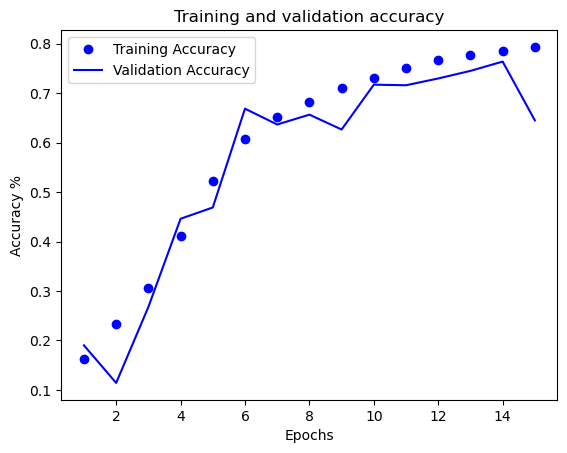

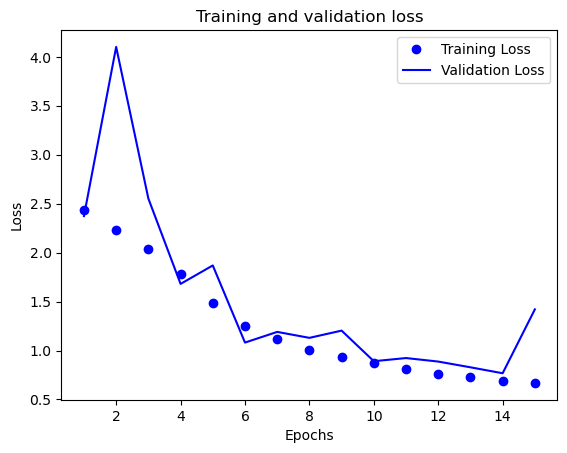

In [4]:
# Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

# Produce a plot for model accuracy 
plt.plot(epochs,accuracy,"bo",label="Training Accuracy")
plt.plot(epochs,val_accuracy,"b",label="Validation Accuracy")
plt.ylabel("Accuracy %")
plt.xlabel("Epochs")
plt.title("Training and validation accuracy")
plt.legend()
plt.savefig("Species Classification Accuracy BW.png")

# Produce a plot for model loss
plt.figure()
plt.plot(epochs,loss,"bo",label="Training Loss")
plt.plot(epochs,val_loss,"b",label="Validation Loss")
plt.title("Training and validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig("Species Classification Loss BW.png")

# Display an output for both of the plots.
plt.show()